# DV2607 Project Notebook
### Authors:
### Oliver Ljung (ollj19@student.bth.se)
### Phoebe Waters (phaa19@student.bth.se)

## Importing modules and dataset

In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf

from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense, Input, Activation, BatchNormalization, LeakyReLU, Reshape, UpSampling2D, Dropout, ReLU
from keras import Sequential, Model
from keras.datasets import mnist
from keras.utils import to_categorical
import keras.backend as KB

from keras.losses import BinaryCrossentropy, CategoricalCrossentropy, Hinge, SquaredHinge, MeanSquaredError, Loss

import random
import time

## Defining functions

In [2]:
# Defining functions

def create_classifier():
    # Create a CNN model
    # Add input
    input = Input(shape = (28,28,1))

    model = Sequential(name="mnist_classifier")

    # Add Convolution layers
    model.add(Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1), name="image_input"))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))

    model.add(Flatten())

    # Add predictive layers
    model.add(Dense(56, activation='relu'))
    model.add(Dense(10, activation='softmax', name="classication_output"))
    
    print(model.summary())

    # Get ouput from model
    prediction = model(input)

    # return model
    return Model(input, prediction, name="mnist_classifier")

def create_generator():
    # Create a CNN model
    model = Sequential(name="generator")

    model.add(Dense(7*7*28, activation='relu', input_dim=100, name="noise_input"))
    model.add(Reshape((7,7,28)))

    model.add(UpSampling2D())
    model.add(Conv2D(28, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1, (3,3), activation='relu', padding="same"))
    model.add(Activation('tanh', name="image_output"))

    print(model.summary())

    input = Input(shape = (100))
    
    img = model(input)
    
    # return model
    return Model(input, img, name="generator")

def create_adv_generator():
    # Create a CNN model

    # Enocder
    encoder = Sequential(name="adv_generator_encoder")
    encoder.add(Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(28,28,1), name="image_input"))
    encoder.add(BatchNormalization(momentum=0.8))
    encoder.add(UpSampling2D())
    
    encoder.add(Conv2D(124, (3,3), padding="same"))
    encoder.add(BatchNormalization(momentum=0.8))
    encoder.add(LeakyReLU(alpha=0.2))

    # Bottle neck w residual block
    resblock = Sequential(name="resblock")
    resblock.add(Conv2D(124, (3,3), padding="same"))
    resblock.add(BatchNormalization(momentum=0.8))
    resblock.add(ReLU())

    resblock.add(Dropout(0.25))

    resblock.add(Conv2D(124, (3,3), padding="same"))
    resblock.add(BatchNormalization(momentum=0.8))

    resblock.add(Conv2D(124, (3,3), padding="same"))
    resblock.add(BatchNormalization(momentum=0.8))
    resblock.add(ReLU())

    resblock.add(Dropout(0.25))

    resblock.add(Conv2D(124, (3,3), padding="same"))
    resblock.add(BatchNormalization(momentum=0.8))

    resblock.add(Conv2D(124, (3,3), padding="same"))
    resblock.add(BatchNormalization(momentum=0.8))
    resblock.add(ReLU())

    resblock.add(Dropout(0.25))

    resblock.add(Conv2D(124, (3,3), padding="same"))
    resblock.add(BatchNormalization(momentum=0.8))

    # Decoder
    decoder = Sequential(name="adv_generator_decoder")
    decoder.add(Conv2DTranspose(32, (3,3), activation='relu', padding="same"))
    decoder.add(BatchNormalization(momentum=0.8))
    decoder.add(UpSampling2D())

    decoder.add(Conv2DTranspose(64, (3,3), padding="same"))
    decoder.add(LeakyReLU(alpha=0.2))

    decoder.add(MaxPooling2D((4, 4)))
    decoder.add(Conv2DTranspose(1, (3,3), padding="same"))
    decoder.add(Activation('tanh', name="adv_image_output"))
    
    # Combining layers to model
    input = Input(shape = (28,28,1))
    encoding = encoder(input)
    bottleneck = resblock(encoding) + encoding
    bottleneck = resblock(bottleneck) + bottleneck
    bottleneck = resblock(bottleneck) + bottleneck
    perturbations = decoder(bottleneck)
    
    model = Model(input, perturbations, name="adv_generator")
    print(model.summary())
    
    # return model
    return model


def create_discriminator():
    # Create a CNN model
    model = Sequential(name="discriminator")

    # Add Convolution layers
    model.add(Conv2D(32, (3,3), input_shape=(28,28,1), name="image_input"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(124, (3,3), activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Add predictive layers
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid', name="validity_output"))
    
    print(model.summary())

    # Add input
    input = Input(shape = (28,28,1))

    # Get ouput from model
    validity = model(input)

    # return model
    return Model(input, validity, name="discriminator")

## Loading dataset

In [3]:
# load dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.astype("float32") / 255
test_X = test_X.astype("float32") / 255

train_X = np.expand_dims(train_X, -1)
test_X = np.expand_dims(test_X, -1)

train_y = to_categorical(train_y)
test_y  = to_categorical(test_y)

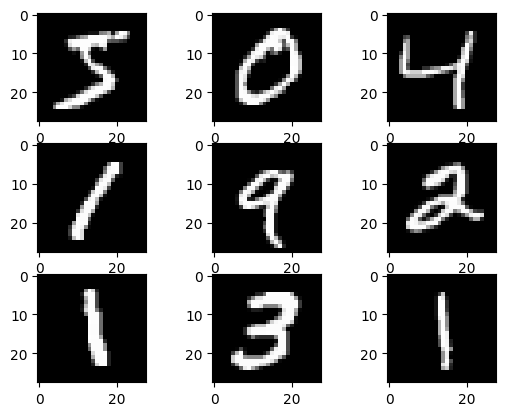

In [4]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

## Training the Classifier; model to attack and later defend

In [5]:
optimizer = tf.optimizers.Adam()

model = create_classifier()
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=["accuracy"])

model.fit(train_X, train_y)
model.save_weights("classifier.h5")

Model: "mnist_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (Conv2D)        (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 56)          28280     
                                                                 
 flatten (Flatten)           (None, 504)          

### Model baseline

In [6]:
model.evaluate(test_X, test_y)

313/313 [==============================] - 2s 5ms/step - loss: 0.0675 - accuracy: 0.9766


[0.06747832149267197, 0.9765999913215637]

## Defining models and input tensors

In [16]:
### Values for advGAN ###
alpha = 2
beta = 1
c = 0.2
#########################

optimizer = tf.optimizers.Adam(learning_rate=0.001)

input = Input(shape=(28,28,1), name="image")

adv_generator = create_adv_generator()
perturbations = adv_generator(input)

adv_image = tf.add(input, perturbations)
adv_image = tf.clip_by_value(adv_image, 0, 1) # Values in image is [0,1]

# We want the generator and discriminator to be trained in a combined model but as seperate entities
discriminator = create_discriminator()
discriminator.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=["accuracy"])
discriminator.trainable = False
validity = discriminator(adv_image)

# We dont want to train our model to attack
model.trainable = False
prediction = model(adv_image)

outputs_w_names = {
    "mnist_classifier": prediction,
    "discriminator": validity,
    "adv_generator": perturbations,
}

advGAN_model = Model(inputs=input, outputs=outputs_w_names, name="advGAN-net")

class PerturbationLoss(Loss):
  def call(self, y_true, y_pred):
    # Colin Targonski (ctargon), Feb-2019, link: https://github.com/ctargon/AdvGAN-tf/blob/master/AdvGAN.py
    zeros = tf.zeros((tf.shape(perturbations)[0]))
    L_hinge = tf.reduce_mean(tf.maximum(zeros, tf.norm(tf.reshape(y_pred, (tf.shape(y_pred)[0], -1)), axis=1) - c))
    return L_hinge

L_adv = CategoricalCrossentropy()
L_GAN = BinaryCrossentropy()
L_hinge = PerturbationLoss()

losses = {
    "mnist_classifier": L_adv,
    "discriminator": L_GAN,
    "adv_generator": L_hinge,
}

losses_weights = {
    "mnist_classifier": 1,
    "discriminator": alpha,
    "adv_generator": beta,
}

advGAN_model.compile(optimizer=optimizer, loss=losses, loss_weights=losses_weights, metrics=["accuracy"])
advGAN_model.summary()

Model: "adv_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 adv_generator_encoder (Sequent  (None, 56, 56, 124)  36780      ['input_6[0][0]']                
 ial)                                                                                             
                                                                                                  
 resblock (Sequential)          (None, 56, 56, 124)  834024      ['adv_generator_encoder[0][0]',  
                                                                  'tf.__operators__.add_6[0][0]', 
                                                                  'tf.__operators__.ad

## AdvGAN Training

In [17]:
BATCH_SIZE = 128 
EPOCHS = 100

y_real = np.ones((BATCH_SIZE, 1))
y_fake = np.zeros((BATCH_SIZE, 1))

# Targeted Attack
target_label = 0
target_prediction = np.zeros(10)
target_prediction[target_label] = 1
target_prediction = np.array([target_prediction]*BATCH_SIZE)

hinge_limit = np.array([[c]]*BATCH_SIZE)

start_time = time.time()
for epoch in range(EPOCHS):
    # if time.time() - start_time > 60*5:
    #     break   # time limit of 8 hours

    x_real = np.array(random.choices(train_X, k=BATCH_SIZE))
    
    perturbations = adv_generator.predict(x_real, verbose=0)
    x_fake = x_real + perturbations

    y = {
        "mnist_classifier": target_prediction,
        "discriminator": y_real,
        "adv_generator": perturbations
    }
    loss = advGAN_model.train_on_batch(x=x_real, y=y)

    # We want our discriminator to learn about fakes after
    discriminator.train_on_batch(x=x_real, y=y_real)
    discriminator.train_on_batch(x=x_fake, y=y_fake)

    if epoch % 1 == 0:
        print(f"EPOCH: {epoch}")
        print(f"Total loss = {loss[0]} \n\tLosses: adv_generator = {loss[1]}, mnist_classifier = {loss[2]}, discriminator = {loss[3]}\n\tAccuracy: adv_generator = {loss[4]}, mnist_classifier = {loss[5]}, discriminator = {loss[6]} \n")
        # print(f"Total loss = {loss[0]} \n\tLosses: mnist_classifier = {loss[1]}, discriminator = {loss[2]}\n\tAccuracy: mnist_classifier = {loss[3]}, discriminator = {loss[4]} \n")

EPOCH: 0
Total loss = 6.887428283691406 
	Losses: adv_generator = 15.343755722045898, mnist_classifier = 0.7052896022796631, discriminator = 4.647763252258301
	Accuracy: adv_generator = 4.982461905456148e-05, mnist_classifier = 0.15625, discriminator = 0.0078125 

EPOCH: 1
Total loss = 17.50191307067871 
	Losses: adv_generator = 20.344383239746094, mnist_classifier = 10.043296813964844, discriminator = 5.424178600311279
	Accuracy: adv_generator = 0.0, mnist_classifier = 0.0, discriminator = 0.0546875 

EPOCH: 2
Total loss = 22.01527214050293 
	Losses: adv_generator = 24.573341369628906, mnist_classifier = 16.95292854309082, discriminator = 2.6050095558166504
	Accuracy: adv_generator = 0.0, mnist_classifier = 0.0, discriminator = 0.2890625 

EPOCH: 3
Total loss = 19.218652725219727 
	Losses: adv_generator = 23.28713607788086, mnist_classifier = 15.128580093383789, discriminator = 1.7613576650619507
	Accuracy: adv_generator = 0.0, mnist_classifier = 0.0, discriminator = 0.4453125 

EPOCH

KeyboardInterrupt: 

In [10]:
adv_generator.save_weights("mnist_adv_generator2.h5")

In [11]:
discriminator.save_weights("mnist_adv_discriminator2.h5")

1/1 [==============================] - 0s 32ms/step
p_fake = 0, p_real = 6
p_fake = 0, p_real = 6
p_fake = 8, p_real = 7
p_fake = 2, p_real = 2
p_fake = 7, p_real = 7
p_fake = 8, p_real = 7
p_fake = 1, p_real = 1
p_fake = 2, p_real = 2
p_fake = 0, p_real = 8


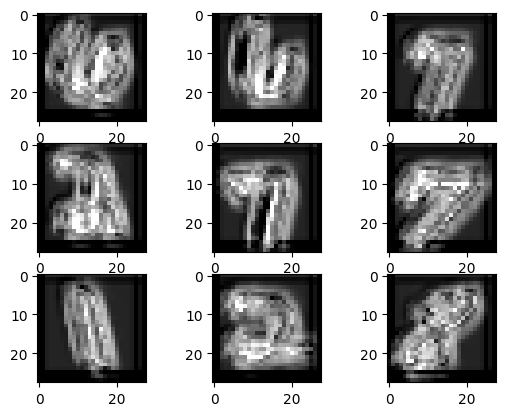

In [18]:
x_real = np.array(random.choices(test_X, k=9))

perturbations = adv_generator.predict(x_real)
x_fake = tf.add(x_real, perturbations)
x_fake = tf.clip_by_value(x_fake, 0, 1) # Values in image is [0,1]
x_fake_labels = model.predict(x_fake)
x_real_labels = model.predict(x_real)

for i in range(9):
    fig = plt.subplot(3, 3, i+1)
    fig.imshow(x_fake[i], cmap=plt.get_cmap('gray'))
    print(f'p_fake = {np.argmax(x_fake_labels[i])}, p_real = {np.argmax(x_real_labels[i])}')
plt.show()

array([[[-0.23532946],
        [-0.01342682],
        [ 0.16141091],
        [ 0.16448656],
        [ 0.1599695 ],
        [ 0.11452617],
        [ 0.03704463],
        [ 0.05531255],
        [ 0.14422473],
        [ 0.20773903],
        [ 0.22879514],
        [ 0.2879494 ],
        [ 0.30832693],
        [ 0.25350112],
        [ 0.18131302],
        [ 0.16536248],
        [ 0.16161789],
        [ 0.16057125],
        [ 0.16033009],
        [ 0.15984435],
        [ 0.1592706 ],
        [ 0.15876077],
        [ 0.15857993],
        [ 0.15744889],
        [ 0.14388783],
        [ 0.06709822],
        [ 0.22328241],
        [-0.04982732]],

       [[-0.14215784],
        [-0.09929658],
        [ 0.06819027],
        [ 0.05690444],
        [ 0.01654897],
        [-0.07703216],
        [ 0.02101123],
        [ 0.07487709],
        [ 0.2453019 ],
        [ 0.30596673],
        [ 0.19060999],
        [ 0.27930278],
        [ 0.25933698],
        [ 0.19356768],
        [ 0.08939616],
        [

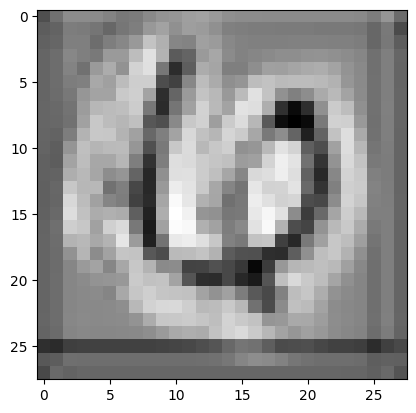

In [19]:
plt.imshow(perturbations[0], cmap=plt.get_cmap('gray'))
hinge_limit = np.full(shape=(1, 28,28,1), fill_value=c)
perturbations[0]